# Inspect

> (Notebooke only) Interactive exploration of trained encoder and embeddings

In [ ]:
#| eval: false
import os
assert False == os.path.isdir('/app/data'), "Do not try to run this on solveit. The memory requirements will crash the VM."

In [ ]:
#| eval: false
import torch
from torch.utils.data import DataLoader
from omegaconf import OmegaConf
from midi_rae.vit import ViTEncoder
from midi_rae.data import PRPairDataset
from midi_rae.viz import make_emb_viz
import matplotlib.pyplot as plt

# Interactive visualization (without wandb logging)
import plotly.io as pio
pio.renderers.default = 'notebook'
from midi_rae.viz import umap_project, pca_project, plot_embeddings_3d, make_emb_viz


## Config

In [ ]:
#| eval: false
cfg = OmegaConf.load('../configs/config.yaml')
#device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu'  # leave GPU free for training while we do analysis here.
print(f'device = {device}')

device = cpu


## Load Dataset

In [ ]:
#| eval: false
val_ds = PRPairDataset(image_dataset_dir=cfg.data.path, split='val', max_shift_x=cfg.training.max_shift_x, max_shift_y=cfg.training.max_shift_y)
val_dl = DataLoader(val_ds, batch_size=cfg.training.batch_size, num_workers=4, drop_last=True)
print(f'Loaded {len(val_ds)} validation samples, batch_size = {cfg.training.batch_size}')

Loading 91 val files from /home/shawley/datasets/POP909_images_basic...
Finished loading.
Loaded 9100 validation samples, batch_size = 768


## Inspect Data

In [ ]:
#| eval: false
batch = next(iter(val_dl))
img1, img2, deltas, file_idx = batch['img1'].to(device), batch['img2'].to(device), batch['deltas'].to(device), batch['file_idx'].to(device)
print("img1.shape, deltas.shape, file_idx.shape =",img1.shape, deltas.shape, file_idx.shape)

img1.shape, deltas.shape, file_idx.shape = torch.Size([768, 1, 128, 128]) torch.Size([768, 2]) torch.Size([768])


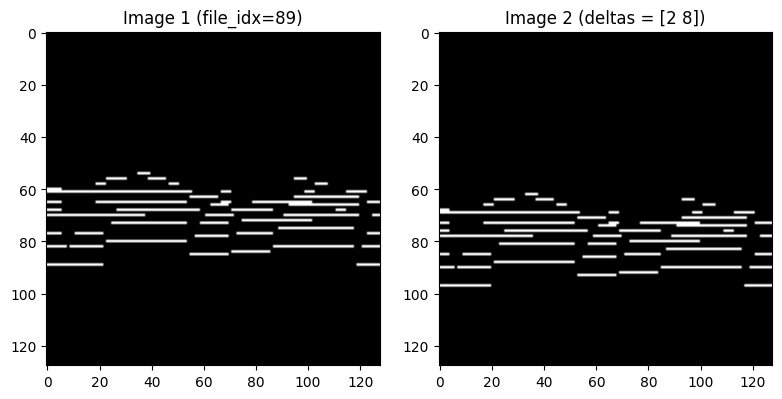

In [ ]:
#| eval: false
# Show a sample image pair
idx = 0
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img1[idx, 0].cpu(), cmap='gray')
axes[0].set_title(f'Image 1 (file_idx={file_idx[idx].item()})')
axes[1].imshow(img2[idx, 0].cpu(), cmap='gray')
axes[1].set_title(f'Image 2 (deltas = {deltas[idx].cpu().int().numpy()})')
plt.tight_layout()
plt.show()

## Load Encoder from Checkpoint

In [ ]:
#| eval: false
ckpt_path = '../checkpoints/enc_best.pt'  # <-- change as needed

model = ViTEncoder(cfg.data.in_channels, (cfg.data.image_size, cfg.data.image_size), 
                   cfg.model.patch_size, cfg.model.dim, cfg.model.depth, cfg.model.heads).to(device)

ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
state_dict = {k.replace('_orig_mod.', ''): v for k, v in ckpt['model_state_dict'].items()}
model.load_state_dict(state_dict, strict=False)
model.eval()
print(f'Loaded checkpoint from {ckpt_path}, epoch {ckpt.get("epoch", "?")}, val_loss {ckpt.get("val_loss","?"):.4f}')

Loaded checkpoint from ../checkpoints/enc_best.pt, epoch 653, val_loss 0.3255


## Run Batch Through Encoder

In [ ]:
#| eval: false
with torch.no_grad():
    enc_out1 = model(img1)
    enc_out2 = model(img2)

    z1 = enc_out1.patches.all_emb.reshape(-1, enc_out1.patches[1].dim)
    z2 = enc_out2.patches.all_emb.reshape(-1, enc_out2.patches[1].dim)
    num_tokens = enc_out1.patches.all_emb.shape[1]

print(f'z1: {z1.shape}, z2: {z2.shape}, num_tokens: {num_tokens}')

## Visualize Embeddings

**NOTE:** This will visualize all embeddings in the entire batch, not just the single pair of images shown above.

In [ ]:
#| eval: false
figs = make_emb_viz((enc_out1, enc_out2), model=model, batch=batch, do_umap=False)
figs.keys() # show what figures are available

In [ ]:
#| eval: false
figs['cls_pca_fig'].show()

Note how the CLS tokens are nicely grouped in pairs.  Let's see if the same is true for the randomly-sampled pairs of non-empty patch embeddings 🤞:

In [ ]:
#| eval: false
figs['patch_pca_fig'].show()

## SVD Analysis

In [ ]:
def svd_analysis(enc_out, level=1,  title='', top_k=20):
    "Run SVD on encoder output, plot singular value spectrum and cumulative variance"
    z = enc_out.patches[level].emb.detach().cpu().float().reshape(-1, enc_out.patches[level].dim)  # flatten batch
    z = z - z.mean(dim=0)  # center
    U, S, Vt = torch.linalg.svd(z, full_matrices=False) # Vt for "V transpose" (technically it's "V hermitian" but we've got real data)
    var_exp = (S**2) / (S**2).sum()
    cum_var = var_exp.cumsum(0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    ax1.semilogy(S.numpy()); ax1.axvline(x=top_k, color='r', ls='--', alpha=0.5)
    ax1.set(xlabel='Component', ylabel='Singular value', title=f'{title} Singular Values')
    ax2.bar(range(top_k), var_exp[:top_k].numpy())
    ax2.set(xlabel='Component', ylabel='Variance explained', title=f'{title} Top {top_k} Variance')
    ax3.plot(cum_var.numpy()); ax3.axhline(y=0.9, color='r', ls='--', alpha=0.5, label='90%')
    ax3.set(xlabel='Component', ylabel='Cumulative variance', title=f'{title} Cumulative Variance')
    ax3.legend()
    plt.tight_layout(); plt.show()

    n90 = (cum_var < 0.9).sum().item() + 1
    print(f"{title}: {n90} components for 90% variance, top-1 explains {var_exp[0]:.1%}")
    return S, U, Vt, var_exp

In [ ]:
#| eval: false
S, U, Vt, var_exp = svd_analysis(enc_out2, title='Patches')

In [ ]:
#| eval: false
cls_S, cls_U, cls_Vt, cls_var_exp = svd_analysis(enc_out2, level=0, title='CLS')

**Two key takeaways:**

1. **Patches need 178/256 dims for 90%.** The representation is highly distributed with no dominant direction. This means the encoder is using nearly all its capacity, which is healthy (no dimensional collapse). But it also suggests rhythm and pitch aren't cleanly factored — if they were, you'd expect a sharper elbow in the spectrum (the first 1 or 2 components notwithstanding). 
2. **CLS only needs 23/256 dims.** The global summary is much more compressed. That's interesting for generation: it suggests the "gist" of a musical passage lives in a ~23-dimensional subspace. The gradual slope in the top-20 bars (no single dominant component) means it's not collapsing to a trivial representation either.